In [1]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

import math
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from scipy import optimize
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
from scipy.stats import sem

import tkinter as tk
import tkinter.filedialog
import tkinter.messagebox
import os
import glob
import time

from ast import literal_eval


import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 8
axis_font_size = 8

from matplotlib.ticker import MaxNLocator

### Execute the next cell if you have a jupyter dark theme
Don't if you don't or don't know what this means
onedork theme jt -t onedork -cellw 80% -T

get white graphs jt -r

https://medium.com/datadriveninvestor/how-can-i-customize-jupyter-notebook-into-dark-mode-7985ce780f38

In [3]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

#restart the core in case you executed the cell in white theme and cannot see ticks anymore

### Declare functions

In [2]:
  
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))

def gaussian_fit_simple_results(data, oversampling = 10, guessed_width = 20):
    
    #########
    #########fit gaussian in left window to find center of band
    #########
    min_x =  np.min(data)
    max_x =  np.max(data)
    if math.isnan(max_x-min_x) or round((max_x-min_x)*oversampling)==0:
        pars, hData_filtered, hData_filtered_x = [], [], []
    else:  
        bins_single = int(round((max_x-min_x)*oversampling))
        # histogram of positions along the x axis
        h_filtered = np.histogram(data)#, bins = bins_single)  
        #histogram height
        hData_filtered = h_filtered[0]
        ###get the center of each bin
        # bin size
        step = (h_filtered[1][1]-h_filtered[1][0])
        hData_filtered_x = h_filtered[1][:len(h_filtered[1])-1]+step/2
        #guess that band is centered on the window
        guess = [np.mean(hData_filtered), np.mean(hData_filtered_x), guessed_width]
        
        try:
            pars, cov = curve_fit(f=gaussian, xdata=hData_filtered_x, ydata=hData_filtered, p0=guess, bounds=(-np.inf, np.inf))
        except:
            pars = []
    return pars, hData_filtered, hData_filtered_x

def set_size(w,h, ax=None):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

## Load result of analysis - with sarcomere length

In [3]:
root = tk.Tk()
loc_filename = tk.filedialog.askopenfilename(parent=root, 
                                             title='Please select the file containing the result of your analysis')
root.withdraw()

all_results = pd.read_csv(loc_filename)

#create a new column to estimate sarcomere length later on
#sarcomere_lengths = [0.0]*len(all_results)
#all_results['sarcomere_length'] = sarcomere_lengths
#all_results.head(3)

## filter with year

In [4]:
# Save results with sarcomere length to avoid extracting sarcomere length each time
#filename_with_sarc = r'C:\Users\pierr\Desktop\Sarcomere simulation\All_results_with_sarc_length.csv'
#all_results.to_csv(filename_with_sarc)
pd.set_option('display.max_rows', None)
all_results['year2020'] = all_results['day'] > 200000
all_results.head(1000)

,Unnamed: 0,day,fly_sample,nanobody,fly_number,selection,probe,dye,zdisk,band_distance,band_positions,band_widths,band_widths_estimate,sarcomere_length,year2020
0,0,200818,1,Nano 42,1,6,P1,Atto643,2,206.748490,"[32.867915486650446, 34.458288488683436]","[0.21851438896533762, 0.22615895125313176]","[0.22240971972258616, 0.2279757313209527]",0.000000,True
1,1,200818,1,Nano 42,1,6,P1,Atto643,3,216.613983,"[60.533437572902734, 62.19969898373392]","[0.23683047815752153, 0.24357284523467207]","[0.16570896401710278, 0.2379513937915265]",0.000000,True
2,2,200818,1,Nano 42,1,7,P1,Atto643,1,204.493419,"[7.661997634895327, 9.235023931065665]","[0.4396865056549227, 0.24527892422835432]","[0.3556327089229639, 0.2308696421266542]",0.000000,True
3,3,200818,1,Nano 42,1,7,P1,Atto643,2,187.637090,"[36.381442767586144, 37.82480499872456]","[0.2516178183522468, 0.2151535553483115]","[0.21530918040950206, 0.1978635282552481]",3712.464804,True
4,4,200818,1,Nano 42,1,7,P1,Atto643,3,193.426990,"[64.81940395432957, 66.30730387812818]","[0.18249507172917895, 0.2081670817635209]","[0.17913721532571136, 0.20948512962670043]",3685.536838,True
5,5,200818,1,Nano 42,1,7,P1,Atto643,4,213.577221,"[92.98223977227072, 94.62514147245776]","[0.2094361801242504, 0.19724862698471987]","[0.2700776978033651, 0.21740176036158912]",0.000000,True
6,6,200818,1,Nano 42,1,8,P1,Atto643,2,210.757626,"[38.86207462522417, 40.48328713415544]","[0.19762387379174462, 0.2295100701289125]","[0.2300581127532284, 0.24829400224914694]",0.000000,True
7,7,200818,1,Nano 42,1,8,P1,Atto643,3,199.678112,"[67.06555442556487, 68.60153990074515]","[0.24906985406773433, 0.22358487941369987]","[0.23270120087123433, 0.2871804383972764]",3683.278503,True
8,8,200818,1,Nano 42,1,8,P1,Atto643,4,202.254311,"[95.56060280886564, 97.11640519949574]","[0.24503221380647247, 0.24961249192530768]","[0.248226096224383, 0.19385759304704006]",0.000000,True
9,9,200818,1,Nano 42,1,10,P1,Atto643,2,180.161765,"[31.993829127091963, 33.379688858717856]","[0.23849994663926954, 0.2939537208401544]","[0.2481865963917902, 0.2224873675525938]",0.000000,True


## Fig 4 histograms for given experiments

In [47]:
del data_fig4_full

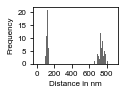

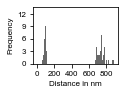

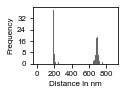

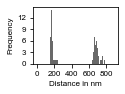

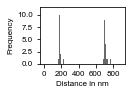

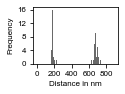

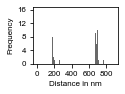

In [48]:
#from matplotlib import style
#plt.style.use('classic')

samples = [5,4,17,9,11,13,15]
FOVs = [1,2,2,2,2,1,1]
day_start_with = 20

data_fig4_full = pd.DataFrame(columns = ['fly_sample', 'fly_number', 'selection', 'zdisk',
                                         'nanobody','band_distance'])
#samples = all_results.fly_sample.unique()
#print(samples)
for i in range(len(samples)):
    cond1 = all_results['fly_sample'] == str(samples[i])
    cond2 = all_results['fly_number'] == (FOVs[i])
    cond3 = all_results['year2020'] != True
    #cond = cond1 and cond2 and cond3
    sample_data = all_results[cond1 & cond2 & cond3]
    #sample_data = sample_data[cond3]
    #print(sample_data)
    nanobodies_sample = sample_data.nanobody.unique()
    
    df = sample_data['band_distance']

    arr = df.to_numpy()
    arr = np.vstack(arr)
    arr = arr.reshape(-1)
    pd.DataFrame(df).to_csv(r'C:\Users\pierr\Desktop\PAINT\figures and text\Fig_4_sample'+str(samples[i])+'.csv', index=False)
    
    for nano in nanobodies_sample:
        cond4 = sample_data['nanobody'] == nano
        df_sub_selection = sample_data[cond4]
        dist_array = (df_sub_selection['band_distance']).to_numpy()
        arr_selection = (df_sub_selection['selection']).to_numpy()
        arr_zdisk = (df_sub_selection['zdisk']).to_numpy()

        for j in range(len(dist_array)):
            new_row = {'fly_sample':samples[i], 'fly_number':FOVs[i], 'selection':arr_selection[j],
                       'zdisk':arr_zdisk[j],'nanobody':nano,'band_distance':dist_array[j]}
            data_fig4_full = data_fig4_full.append(new_row, ignore_index=True)

    '''
    width_gauss = 10
    x_span = np.arange(min(arr)-5*width_gauss, max(arr)+5*width_gauss, .2*width_gauss)
    gaussed = np.zeros(len(x_span))
    for k in arr:
        gaussed = gaussed + np.exp(-(x_span-k)**2/(2*width_gauss))
    plt.plot(x_span,gaussed)
    plt.show()
    '''
    bins_hist = np.arange(0,900, 10)
    
    def set_size(w,h, ax=None):
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    fig, ax=plt.subplots()

    #ax.plot([1,3,2])

    #ax = plt.figure(figsize=((1+3.5)/2.54,(2+1)/2.54)).gca()
    
    plt.hist(arr, facecolor="dimgrey",bins = bins_hist, alpha=1)#, density = True)
    #plt.hist(arr, facecolor=color_nano[k], alpha=1, histtype='step', density = True)
    #plt.title(nanobodies_sample[0]+'_'+nanobodies_sample[1])
    plt.xlabel('Distance in nm')
    plt.ylabel('Frequency')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(5)) 
    ax.xaxis.set_major_locator(MaxNLocator(5)) 
    set_size(3/2.54,2/2.54)
    #plt.tight_layout()
    #plt.margins(1, tight=True)
    #plt.savefig('C:\\Users\\pierr\\Desktop\\PAINT\\Sarcomere simulation\\graphs\\fig4_hist_sample_'+str(samples[i])+'_'+nanobodies_sample[0]+'_'+nanobodies_sample[1]+'.pdf')
    plt.show()
    #sns.kdeplot(data=arr)
    #plt.show()
    #sns.distplot(arr  ,  bins = 100 , kde = False , color = 'teal'\
    #         , kde_kws=dict(linewidth = 4 , color = 'black'))
    #plt.show()
#all_results.head(10)
data_fig4_full.to_csv(r'C:\Users\pierr\Desktop\PAINT\figures and text\Fig_4_sample_full.csv')

## Fig3 example

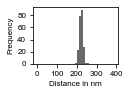

In [52]:
#from matplotlib import style
#plt.style.use('classic')

samples = [7]
FOVs = [1]
nanobody = ['Nano 29']
#day_start_with = 20

#samples = all_results.fly_sample.unique()
#print(samples)
for i in range(len(samples)):
    cond1 = all_results['fly_sample'] == str(samples[i])
    cond2 = all_results['fly_number'] == (FOVs[i])
    cond3 = all_results['nanobody'] == nanobody[i]
    #cond = cond1 and cond2 and cond3
    sample_data = all_results[cond1 & cond2 & cond3]
    #sample_data = sample_data[cond3]
    #print(sample_data)
    nanobodies_sample = sample_data.nanobody.unique()
    
    df = sample_data['band_distance']
    arr = df.to_numpy()
    arr = np.vstack(arr)
    arr = arr.reshape(-1)
    '''
    width_gauss = 10
    x_span = np.arange(min(arr)-5*width_gauss, max(arr)+5*width_gauss, .2*width_gauss)
    gaussed = np.zeros(len(x_span))
    for k in arr:
        gaussed = gaussed + np.exp(-(x_span-k)**2/(2*width_gauss))
    plt.plot(x_span,gaussed)
    plt.show()
    '''
    bins_hist = np.arange(0,400, 10)
    
    def set_size(w,h, ax=None):
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    fig, ax=plt.subplots()

    #ax.plot([1,3,2])

    #ax = plt.figure(figsize=((1+3.5)/2.54,(2+1)/2.54)).gca()
    
    plt.hist(arr, facecolor="dimgrey",bins = bins_hist, alpha=1)#, density = True)
    #plt.hist(arr, facecolor=color_nano[k], alpha=1, histtype='step', density = True)
    #plt.title(nanobodies_sample[0]+'_'+nanobodies_sample[1])
    
    df.to_csv(r'C:\Users\pierr\Desktop\PAINT\figures and text\Fig_3_hist.csv')
    
    plt.xlabel('Distance in nm')
    plt.ylabel('Frequency')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(5)) 
    ax.xaxis.set_major_locator(MaxNLocator(5)) 
    set_size(3/2.54,2/2.54)
    #plt.tight_layout()
    #plt.margins(1, tight=True)
    #plt.savefig('C:\\Users\\pierr\\Desktop\\PAINT\\Sarcomere simulation\\graphs\\fig3_hist_example_'+str(samples[i])+
    #            '_'+str(FOVs[i])+'_'+nanobody[i]+'.pdf')
    plt.show()
    #sns.kdeplot(data=arr)
    #plt.show()
    #sns.distplot(arr  ,  bins = 100 , kde = False , color = 'teal'\
    #         , kde_kws=dict(linewidth = 4 , color = 'black'))
    #plt.show()
#all_results.head(10)

## Fig 5 and its supplement - One nanobody versus another (each experiment one color)

['1' '2' '3' '6' '7' '8' '9' '14' '14b']
['Nano 42' 'Nano 2']
0
14


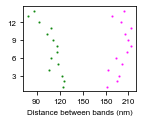

['Nano 29' 'Nano 30']
0
219


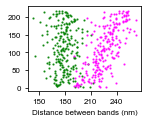

['Nano 29' 'Nano 33']
0
52


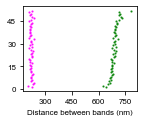

['Nano 46' 'Nano 29']
0
4


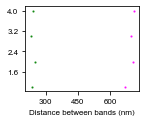

['Nano 39' 'Nano 29']
0
21


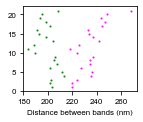

['Nano 42' 'Nano 30']
3
42


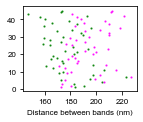

In [17]:
def set_size(w,h, ax=None):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

color_closer = ['green', 'green', 'magenta', 'green', 'green', 'green', 'green', 'green', 'green', 'green']    
color_further = ['magenta', 'magenta', 'green', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta']   


years = all_results.year2020.unique()
color_nano = ['tab:blue','tab:green','tab:purple','tab:cyan', 'tab:olive']
k = 0

dataframe = all_results[all_results['year2020'] == True]

samples = dataframe.fly_sample.unique()
print(samples)

for i in samples:
    cond = dataframe['fly_sample'] == i
    sample_df = dataframe[cond]
    sample_nanobody = sample_df.nanobody.unique()
    sample_fly_number = sample_df.fly_number.unique()
    if len(sample_nanobody) > 1:
        print(sample_nanobody)


        band_dist_nano1 = []
        band_dist_nano2 = []
        for j in sample_fly_number:

            cond1 = sample_df['fly_number'] == j
            fly_df = sample_df[cond1]
            selections = fly_df.selection.unique()
            for l in selections:
                cond2 = fly_df['selection'] == l
                selection_df = fly_df[cond2]
                zdisks = selection_df.zdisk.unique()
                for m in zdisks:
                    cond3 = selection_df['zdisk'] == m
                    zdisk_df = selection_df[cond3]
                    if len(zdisk_df) == 2:
                        band_distance_zdisk_df = zdisk_df['band_distance']
                        arr_band_dist = band_distance_zdisk_df.to_numpy()
                        arr_band_dist = np.vstack(arr_band_dist)
                        band_distance_zdisk = arr_band_dist.reshape(-1)

                        nanobodies_zdisk_df = zdisk_df['nanobody']
                        arr_zdisk = nanobodies_zdisk_df.to_numpy()
                        arr_zdisk = np.vstack(arr_zdisk)
                        nanobodies_zdisk = arr_zdisk.reshape(-1)

                        if nanobodies_zdisk[0] == sample_nanobody[0]:
                            band_dist_nano1 = np.append(band_dist_nano1, band_distance_zdisk[0])
                            band_dist_nano2 = np.append(band_dist_nano2, band_distance_zdisk[1])
                        else:
                            band_dist_nano1 = np.append(band_dist_nano1, band_distance_zdisk[1])
                            band_dist_nano2 = np.append(band_dist_nano2, band_distance_zdisk[0])

        if np.mean(band_dist_nano1) > np.mean(band_dist_nano2):
            closer_band = band_dist_nano2
            further_band = band_dist_nano1
        else:
            closer_band = band_dist_nano1
            further_band = band_dist_nano2

        diff_dist = further_band-closer_band
        df = pd.DataFrame({'dist': diff_dist, 'bd1' : closer_band, 'bd2' : further_band})
        df = df.sort_values(by=['dist'])
        closer_band = df['bd1']
        further_band = df['bd2']
        step = 1
        x = range(1,step*len(closer_band)+1, step)

        fig, ax=plt.subplots()
        plt.scatter(closer_band, x, c = color_closer[k], alpha=0.75, s = 1.5*step)
        plt.scatter(further_band, x, c = color_further[k], alpha=0.75, s = 1.5*step)

        df_pos = df[df['dist'] >= 0]
        df_neg = df[df['dist'] < 0]

        band_dist_nano1_pos = df_pos['bd1']
        band_dist_nano1_neg = df_neg['bd1']
        print(len(band_dist_nano1_neg))
        print(len(band_dist_nano1_pos))
        #print(k)
        '''
        band_dist_nano1_neg = df_neg['bd1']
        band_dist_nano2_neg = df_neg['bd2']
        x = range(len(band_dist_nano1_pos), len(band_dist_nano1_pos)+len(band_dist_nano1_neg))
        plt.scatter(band_dist_nano1_neg, x, c = 'green', alpha=0.2)
        plt.scatter(band_dist_nano2_neg, x, c = 'magenta', alpha=0.2)           
        '''
        plt.xlabel('Distance between bands (nm)')
        #plt.ylabel('Distance between ' + sample_nanobody[1] + ' bands (nm)')
        #plt.title('Distance between bands ' + sample_nanobody[1] + ' vs ' + sample_nanobody[0])

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(5)) 
        ax.xaxis.set_major_locator(MaxNLocator(5)) 
        set_size(4/2.54,3/2.54)

        #plt.savefig('C:\\Users\\pierr\\Desktop\\PAINT\\Sarcomere simulation\\graphs\\fig5_hist_sample_'+
        #            str(i)+'_'+str(sample_nanobody[0])+'_'+str(sample_nanobody[1])+'.pdf')
        plt.show()
        k = k + 1

## With joining lines

In [8]:
del data_fig5

['1' '2' '3' '6' '7' '8' '9' '14' '14b']
['Nano 42' 'Nano 2']
0
14


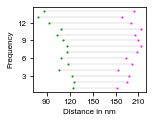

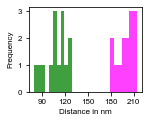

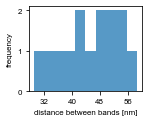

['Nano 29' 'Nano 30']
0
219


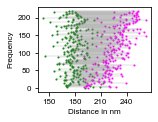

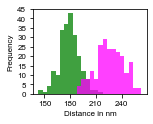

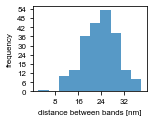

['Nano 29' 'Nano 33']
0
52


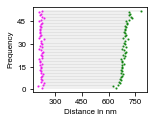

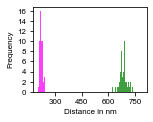

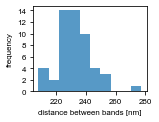

['Nano 46' 'Nano 29']
0
4


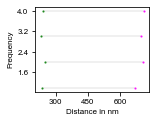

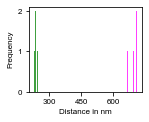

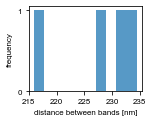

['Nano 39' 'Nano 29']
0
21


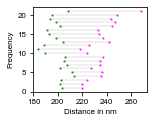

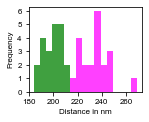

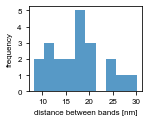

['Nano 42' 'Nano 30']
3
42


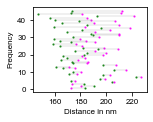

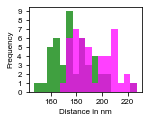

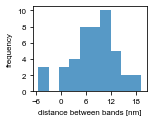

In [7]:
def set_size(w,h, ax=None):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

color_closer = ['green', 'green', 'magenta', 'green', 'green', 'green', 'green', 'green', 'green', 'green']    
color_further = ['magenta', 'magenta', 'green', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta']   


years = all_results.year2020.unique()
color_nano = ['tab:blue','tab:green','tab:purple','tab:cyan', 'tab:olive']
k = 0

dataframe = all_results[all_results['year2020'] == True]

data_fig5 = pd.DataFrame(columns = ['sample', 'fly_number', 'selection', 'zdisk',
                                    'nanobody_1', 'nanobody_2','band_distance_nano1','band_distance_nano2'])

samples = dataframe.fly_sample.unique()
print(samples)

for i in samples:
    cond = dataframe['fly_sample'] == i
    sample_df = dataframe[cond]
    sample_nanobody = sample_df.nanobody.unique()
    sample_fly_number = sample_df.fly_number.unique()
    if len(sample_nanobody) > 1:
        print(sample_nanobody)


        band_dist_nano1 = []
        band_dist_nano2 = []
        for j in sample_fly_number:

            cond1 = sample_df['fly_number'] == j
            fly_df = sample_df[cond1]
            selections = fly_df.selection.unique()
            for l in selections:
                cond2 = fly_df['selection'] == l
                selection_df = fly_df[cond2]
                zdisks = selection_df.zdisk.unique()
                for m in zdisks:
                    cond3 = selection_df['zdisk'] == m
                    zdisk_df = selection_df[cond3]
                    if len(zdisk_df) == 2:
                        band_distance_zdisk_df = zdisk_df['band_distance']
                        arr_band_dist = band_distance_zdisk_df.to_numpy()
                        arr_band_dist = np.vstack(arr_band_dist)
                        band_distance_zdisk = arr_band_dist.reshape(-1)

                        nanobodies_zdisk_df = zdisk_df['nanobody']
                        arr_zdisk = nanobodies_zdisk_df.to_numpy()
                        arr_zdisk = np.vstack(arr_zdisk)
                        nanobodies_zdisk = arr_zdisk.reshape(-1)
                        
                        new_row = {'sample':i, 'fly_number':j, 'selection':l, 'zdisk':m,
                                   'nanobody_1':nanobodies_zdisk[0], 'nanobody_2':nanobodies_zdisk[1],
                                   'band_distance_nano1':band_distance_zdisk[0],
                                   'band_distance_nano2':band_distance_zdisk[1]}
                        data_fig5 = data_fig5.append(new_row, ignore_index=True)


                        if nanobodies_zdisk[0] == sample_nanobody[0]:
                            band_dist_nano1 = np.append(band_dist_nano1, band_distance_zdisk[0])
                            band_dist_nano2 = np.append(band_dist_nano2, band_distance_zdisk[1])
                        else:
                            band_dist_nano1 = np.append(band_dist_nano1, band_distance_zdisk[1])
                            band_dist_nano2 = np.append(band_dist_nano2, band_distance_zdisk[0])

        if np.mean(band_dist_nano1) > np.mean(band_dist_nano2):
            closer_band = band_dist_nano2
            further_band = band_dist_nano1
        else:
            closer_band = band_dist_nano1
            further_band = band_dist_nano2

        diff_dist = further_band-closer_band
        df = pd.DataFrame({'dist': diff_dist, 'bd1' : closer_band, 'bd2' : further_band})
        df = df.sort_values(by=['dist'])
        df = df.reset_index(drop=True)
        closer_band = df['bd1']
        further_band = df['bd2']
        step = 1
        x = range(1,step*len(closer_band)+1, step)

        fig, ax=plt.subplots()
        plt.scatter(closer_band, x, c = color_closer[k], alpha=0.75, s = 1.5*step)
        plt.scatter(further_band, x, c = color_further[k], alpha=0.75, s = 1.5*step)
        for l in range(len(x)):
            ax.plot([closer_band[l],further_band[l]], [x[l],x[l]], lw = .3, c = 'gray', alpha=0.8)

        df_pos = df[df['dist'] >= 0]
        df_neg = df[df['dist'] < 0]

        band_dist_nano1_pos = df_pos['bd1']
        band_dist_nano1_neg = df_neg['bd1']
        print(len(band_dist_nano1_neg))
        print(len(band_dist_nano1_pos))
        #print(k)
        '''
        band_dist_nano1_neg = df_neg['bd1']
        band_dist_nano2_neg = df_neg['bd2']
        x = range(len(band_dist_nano1_pos), len(band_dist_nano1_pos)+len(band_dist_nano1_neg))
        plt.scatter(band_dist_nano1_neg, x, c = 'green', alpha=0.2)
        plt.scatter(band_dist_nano2_neg, x, c = 'magenta', alpha=0.2)           
        '''
        plt.xlabel('Distance in nm')
        #plt.ylabel('Distance between ' + sample_nanobody[1] + ' bands (nm)')
        #plt.title('Distance between bands ' + sample_nanobody[1] + ' vs ' + sample_nanobody[0])
        
        plt.ylabel('Frequency')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(5)) 
        ax.xaxis.set_major_locator(MaxNLocator(5)) 
        set_size(4/2.54,3/2.54)

        #plt.savefig('C:\\Users\\pierr\\Desktop\\PAINT\\Sarcomere simulation\\graphs\\fig5_sample_'+
        #            str(i)+'_'+str(sample_nanobody[0])+'_'+str(sample_nanobody[1])+'_each_data_point_with_lines.pdf')
        plt.show()
        
        fig, ax=plt.subplots()
        
        min_c = min(closer_band)
        min_f = min(further_band)
        min_t = min([math.floor(min_c), math.floor(min_f)])
        max_c = max(closer_band)
        max_f = max(further_band)
        max_t = max([math.ceil(max_c), math.ceil(max_f)])
        step = 5
        bins = range(min_t, max_t+step, step)
        
        plt.hist(closer_band,bins=bins, color = color_closer[k], alpha=0.75)
        plt.hist(further_band,bins=bins, color = color_further[k], alpha=0.75)
        #ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(5)) 
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        set_size(4/2.54,3/2.54)
        plt.xlabel('Distance in nm')
        plt.ylabel('Frequency')
        #plt.savefig('C:\\Users\\pierr\\Desktop\\PAINT\\Sarcomere simulation\\graphs\\fig5_hist_sample_'+
        #            str(i)+'_'+str(sample_nanobody[0])+'_'+str(sample_nanobody[1])+'.pdf')
        plt.show()
        
        # Histogram of distance between bands
        fig, ax=plt.subplots()
        
        min_c = min(closer_band)
        min_f = min(further_band)
        min_t = min([math.floor(min_c), math.floor(min_f)])
        max_c = max(closer_band)
        max_f = max(further_band)
        max_t = max([math.ceil(max_c), math.ceil(max_f)])
        step = 5
        bins = range(min_t, max_t+step, step)
        
        plt.hist(diff_dist/2, alpha=0.75)
        
        #ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(5)) 
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        set_size(4/2.54,3/2.54)
        plt.xlabel('distance between bands [nm]')
        plt.ylabel('frequency')
        plt.savefig('C:\\Users\\pierr\\Desktop\\PAINT\\Sarcomere simulation\\graphs\\fig5_supp1_hist_sample_'+
                    str(i)+'_'+str(sample_nanobody[0])+'_'+str(sample_nanobody[1])+'.pdf')
        plt.show()
        
        k = k + 1
data_fig5.to_csv(r'C:\Users\pierr\Desktop\PAINT\figures and text\Fig_5_data.csv')      

In [19]:
del data_fig5_supplement


cond1 = all_results['sarcomere_length'] != 0
k = 0

data_fig5_supplement = pd.DataFrame(columns = ['nanobody','band_distance','sarcomere_length'])
#data_fig5_supplement_full = pd.DataFrame()

cond2 = all_results['nanobody'] != 'Nano 46'
sub_df = all_results[cond2 & cond1]


data_fig5_supplement_full = sub_df[['day','fly_sample','nanobody','fly_number','selection','zdisk','band_distance','sarcomere_length']]
data_fig5_supplement_full.to_csv(r'C:\Users\pierr\Desktop\PAINT\figures and text\Fig_5_data_supp_full.csv') 
#data_fig5_supplement_full.head(50)

,day,fly_sample,nanobody,fly_number,selection,zdisk,band_distance,sarcomere_length
3,200818,1,Nano 42,1,7,2,187.637090,3712.464804
4,200818,1,Nano 42,1,7,3,193.426990,3685.536838
7,200818,1,Nano 42,1,8,3,199.678112,3683.278503
10,200818,1,Nano 42,1,10,3,205.583083,3674.532785
11,200818,1,Nano 42,1,10,4,207.721379,3712.032023
24,200818,1,Nano 42,1,17,2,199.531044,3702.661175
25,200818,1,Nano 42,1,17,3,224.529837,3717.047489
26,200818,1,Nano 42,1,17,4,220.695248,3707.604024
29,200818,1,Nano 42,1,19,2,205.738885,3693.037816
30,200818,1,Nano 42,1,19,3,189.118548,3675.809597


## Fig 6B

Nano 2
[50.93725318897811, -1.0092790512957848, 1.0028241017441033]
Nano 30
[90.74935263758775, -0.5281481015843212, 0.5182269475017165]
Nano 39
[98.78893065579635, -0.9600589609521961, 1.0604826844904522]
Nano 29
[110.34502546561589, -0.6978893264212616, 0.7321290497681048]
Nano 42
[97.98851893493038, -1.0213888209898982, 1.1004510818640085]
Nano 33
[349.7872978581336, -2.8095863555503797, 3.068697011995141]
Nano 37
[350.99413503051943, -3.4673831548746534, 4.4625476282156455]
Nano 35
[353.4280594880781, -2.7298997292953118, 2.813657466586335]


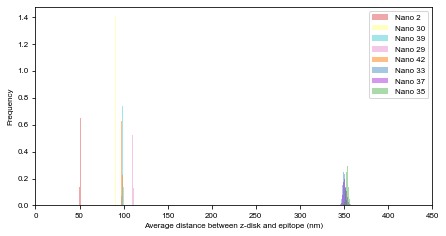

In [50]:
nanobodies_centered = ['Nano 2', 'Nano 30','Nano 39', 'Nano 29', 'Nano 42','Nano 33', 'Nano 37', 'Nano 35']

data_fig6_full = pd.DataFrame(columns = ['nanobody', 'avg_distance'])


color_nano_centered = ['tab:red','yellow','tab:cyan','tab:pink','tab:orange','tab:blue','darkviolet', 'tab:green']
alpha_arr = [0.4,0.25,0.4,0.4,0.5,0.4,0.4,0.4]
k = 0
step = 0.3
bins = np.arange(0, 450+step, step)
for i in nanobodies_centered:
    cond = all_results['nanobody'] == i
    Nano_df = all_results[cond]
    df = Nano_df['band_distance']
    arr = df.to_numpy()
    arr = np.vstack(arr)
    arr = arr.reshape(-1)
    arr = arr/2
    
    sample_mean = []
    for l in range(1000):
        y = np.random.choice(arr, len(arr))
        avg = np.mean(y)
        sample_mean.append(avg)
    print(i)
    print([np.mean(arr), np.quantile(sample_mean, 0.025)-np.mean(arr),np.quantile(sample_mean, 0.975)-np.mean(arr)])
    
    for j in range(len(sample_mean)):
            new_row = {'nanobody':i, 'avg_distance':sample_mean[j]}
            data_fig6_full = data_fig6_full.append(new_row, ignore_index=True)
    
    plt.hist(sample_mean, bins = bins, facecolor=color_nano_centered[k], alpha=alpha_arr[k], density = True, label = nanobodies_centered[k])
    #plt.hist(arr, facecolor=color_nano_centered[k], alpha=1, histtype='step', density = True,rwidth=1)
    center = np.mean(arr)#gaussian_fit_simple_results(arr)[0][1]
    #print(gaussian_fit_simple_results(arr)[0][1])
    #plt.axvline(center, color=color_nano_centered[k], lw=1)#, label = i)
    #stderr = np.std(arr)/np.sqrt(len(arr)-1)
    #plt.axvline(center+3*stderr, color=color_nano_centered[k], dashes = (3,5,3,5), alpha = 0.5)
    #plt.axvline(center-3*stderr, color=color_nano_centered[k], dashes = (3,5,3,5), alpha = 0.5)
    k = k+1
    
#plt.grid(True)
plt.xlabel('Average distance between z-disk and epitope (nm)')
plt.ylabel('Frequency')
#plt.title('Histogram of distance between bands')
plt.xlim(0,450)
#plt.ylim(0,0.1)
plt.legend()
set_size(14/2.54,7/2.54)
#plt.savefig('C:\\Users\\pierr\\Desktop\\PAINT\\Sarcomere simulation\\graphs\\Fig6_Distances_zdisk-epitope_bootstrap.pdf')
plt.show()

data_fig6_full.to_csv(r'C:\Users\pierr\Desktop\PAINT\figures and text\Fig_6_full.csv')

## Fig 6 - supplement 1

Nano 42
91
Nano 2
103
Nano 39
79
Nano 30
499
Nano 29
508
Nano 33
61
Nano 35
79


No handles with labels found to put in legend.


Nano 37
22


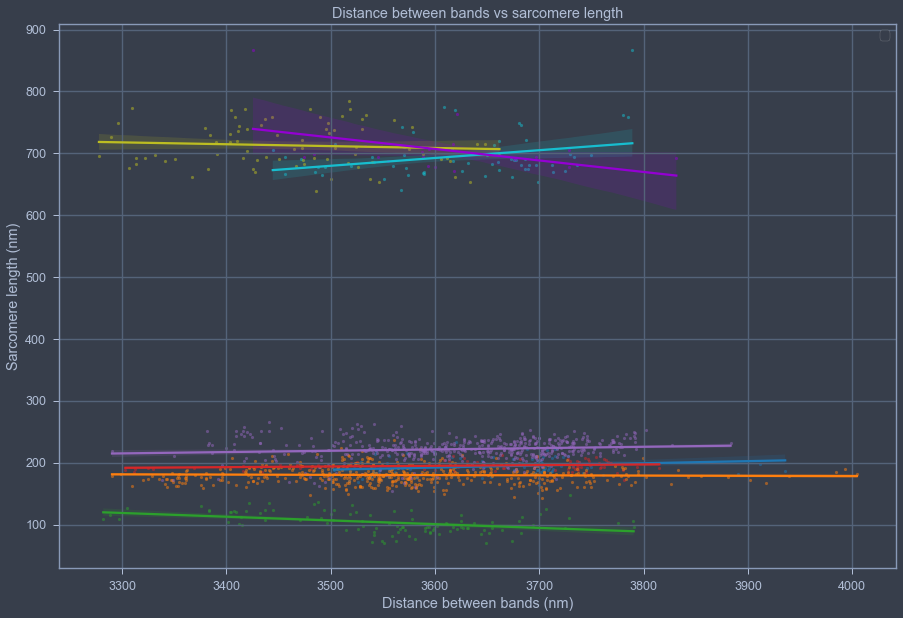

Nano 42
91
Nano 2
103
Nano 39
79
Nano 30
499
Nano 29
508
Nano 33
61
Nano 35
79
Nano 37
22


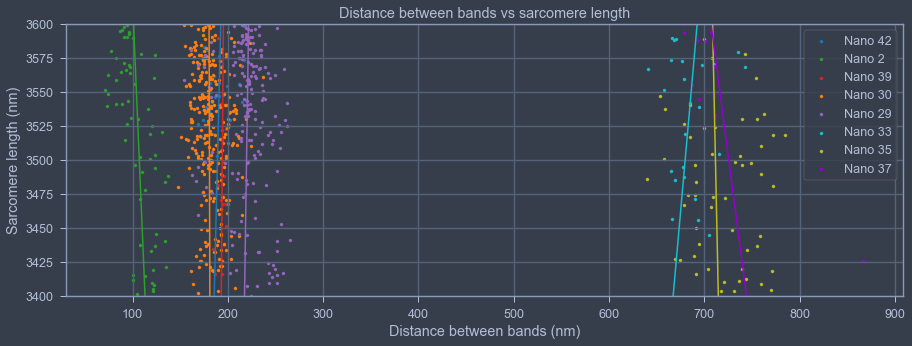

In [36]:
nanobodies = all_results.nanobody.unique()
#nanobodies = nanobodies[:len(nanobodies)-2] # get rid of Nano 46 that creates an error
color_nano_minus46 = ['tab:blue','tab:green','tab:red','tab:orange','tab:purple','tab:cyan', 'tab:olive','darkviolet']
cond1 = all_results['sarcomere_length'] != 0
k = 0
plt.figure(figsize=(15,10))
for i in nanobodies:
    if (i != 'Nano 46'):#&(i != 'Nano 33')&(i != 'Nano 35'):
        print(i)
        cond = all_results['nanobody'] == i
        Nano_df = all_results[cond & cond1]
        print(len(Nano_df))
        df_band_dist = Nano_df['band_distance']
        arr_band_dist = df_band_dist.to_numpy()
        arr_band_dist = np.vstack(arr_band_dist)
        arr_band_dist = arr_band_dist.reshape(-1)

        df_sarc_length = Nano_df['sarcomere_length']
        arr_sarc_length = df_sarc_length.to_numpy()
        arr_sarc_length = np.vstack(arr_sarc_length)
        arr_sarc_length = arr_sarc_length.reshape(-1)
        
        x = arr_sarc_length
        y = arr_band_dist
        #linear_model=np.polyfit(x,y,1)
        #linear_model_fn=np.poly1d(linear_model)
        sns.regplot(x, y, ci=90, color=color_nano_minus46[k], scatter_kws={'s': 10, 'alpha': 0.5})
        
        #x_s=np.arange(3250,4000)
        
        #plt.plot(linear_model_fn(x_s),x_s,color=color_nano_minus46[k])
        
        #plt.scatter(arr_sarc_length, arr_band_dist, facecolor=color_nano_minus46[k],s=10, alpha=0.5, label = i)
        k = k+1
plt.grid(True)
plt.legend()
plt.ylabel('Sarcomere length (nm)')
plt.xlabel('Distance between bands (nm)')
plt.title('Distance between bands vs sarcomere length')
plt.show()


k = 0
plt.figure(figsize=(15,5))
for i in nanobodies:
    if (i != 'Nano 46'):#&(i != 'Nano 33')&(i != 'Nano 35'):
        print(i)
        cond = all_results['nanobody'] == i
        Nano_df = all_results[cond & cond1]
        print(len(Nano_df))
        df_band_dist = Nano_df['band_distance']
        arr_band_dist = df_band_dist.to_numpy()
        arr_band_dist = np.vstack(arr_band_dist)
        arr_band_dist = arr_band_dist.reshape(-1)

        df_sarc_length = Nano_df['sarcomere_length']
        arr_sarc_length = df_sarc_length.to_numpy()
        arr_sarc_length = np.vstack(arr_sarc_length)
        arr_sarc_length = arr_sarc_length.reshape(-1)
        x = arr_sarc_length
        y = arr_band_dist
        linear_model=np.polyfit(x,y,1)
        linear_model_fn=np.poly1d(linear_model)
        x_s=np.arange(3400,3600)
        plt.plot(linear_model_fn(x_s),x_s,color=color_nano_minus46[k])
        
        plt.scatter(arr_band_dist, arr_sarc_length, facecolor=color_nano_minus46[k],s=10, alpha=1, label = i)
        k = k+1
plt.grid(True)
plt.legend()
plt.ylabel('Sarcomere length (nm)')
plt.xlabel('Distance between bands (nm)')
plt.title('Distance between bands vs sarcomere length')
plt.ylim(3400,3600)
plt.show()

### Number of sarcomere extracted for each nanobody

In [6]:
nanobodies = all_results.nanobody.unique()
for i in nanobodies:
    cond = all_results['nanobody'] == i
    Nano_df = all_results[cond]
    df = Nano_df['band_distance']
    print()
    print(i)
    arr = df.to_numpy()
    arr = np.vstack(arr)
    arr = arr.reshape(-1)
    print(len(arr))


Nano 42
183

Nano 2
215

Nano 39
167

Nano 30
787

Nano 29
780

Nano 33
173

Nano 46
4

Nano 35
155

Nano 37
56


## Sum up of all results

In [14]:
nanobodies = all_results.nanobody.unique()
nanobodies = np.sort(nanobodies)
for i in nanobodies:
    #print(i)
    cond = all_results['nanobody'] == i
    Nano_df = all_results[cond] # pick results from one nanobody

    #iterate on day and fly sample and ly number to get to unique experiments  
    zdisks = []
    days = Nano_df.day.unique()
    days = np.sort(days)
    for j in days:
        #print(j)
        cond = Nano_df['day'] == j
        Nano_df2 = Nano_df[cond]
        fly_samples = Nano_df2.fly_sample.unique()
        for k in fly_samples:
            #print(k)
            cond = Nano_df2['fly_sample'] == k
            Nano_df3 = Nano_df2[cond]
            fly_numbers = Nano_df3.fly_number.unique()
            
            # pick data from the other nanobody used in the same day and sample (will still have to pick the same fly)
            cond_all = (all_results['day'] == j) & (all_results['fly_sample'] == k) & (all_results['nanobody'] != i)  
            Nano_other = all_results[cond_all]
            try:other_nano = Nano_other.nanobody.unique()[0] # if there is no data associated to the other nanobody, skips it
            except: other_nano = ""
            print()
            for l in fly_numbers:
                
                cond = Nano_df3['fly_number'] == l
                Nano_df4 = Nano_df3[cond]
                
                probe_nano1 = Nano_df4.probe.unique()[0]
                dye_nano1 = Nano_df4.dye.unique()[0]
                
                #obtain the number of z-disks per experiment
                df = Nano_df4['band_distance']
                arr = df.to_numpy()
                arr = np.vstack(arr)
                arr = arr.reshape(-1)
                nb_zdisks_per_experiment = len(arr)
                zdisks = np.append(zdisks, nb_zdisks_per_experiment)
                
                #obtain the number of z-disks where sarcomere length could be estimated
                df_sarc = Nano_df4['sarcomere_length']
                arr_sarc1 = df_sarc.to_numpy()
                arr_sarc1 = np.vstack(arr_sarc1)
                arr_sarc1 = arr_sarc1.reshape(-1)
                nbsarc1 = 0
                for sarc1 in arr_sarc1:
                    if sarc1 != 0: nbsarc1 = nbsarc1 + 1
                
                cond = Nano_other['fly_number'] == l
                Nano_other_df = Nano_other[cond]
                df = Nano_other_df['band_distance']
                arr2 = df.to_numpy()
                try:
                    probe_nano2 = Nano_other_df.probe.unique()[0]
                    dye_nano2 = Nano_other_df.dye.unique()[0]
                    arr2 = np.vstack(arr2)
                    arr2 = arr2.reshape(-1)
                    nb_zisk_other_nanobody = len(arr2)
                    
                    nano1_selections = Nano_df4.selection.unique()
                    nano2_selections = Nano_other_df.selection.unique()

                    common = 0
                    for sel1 in nano1_selections:
                        for sel2 in nano2_selections:
                            if sel1==sel2:
                                zdisk1 = Nano_df4[Nano_df4['selection']==sel1]['zdisk']
                                zdisk2 = Nano_other_df[Nano_other_df['selection']==sel1]['zdisk']
                                for z1 in zdisk1:
                                    for z2 in zdisk2:
                                        if z1==z2:
                                            common = common + 1
                                
                    df_sarc2 = Nano_other_df['sarcomere_length']
                    arr_sarc2 = df_sarc2.to_numpy()
                    arr_sarc2 = np.vstack(arr_sarc2)
                    arr_sarc2 = arr_sarc2.reshape(-1)
                
                    nbsarc2 = 0
                    for sarc2 in arr_sarc2:
                        if sarc2 != 0: nbsarc2 = nbsarc2 + 1
                except:
                    nb_zisk_other_nanobody = 0
                    common = 0
                    nbsarc2 = 0
                    probe_nano2 = ""
                    dye_nano2 = ""
                    
                
                #Nanobody1	Nanobody2	nb of flies	day	fly sample	nb of nanobody1 Zdisks	nb of nanobody2 Zdisks	n1 and n2 common Zdisks	n1 with sarc length	n2 with sarc length
                print(i, other_nano, probe_nano1, probe_nano2, dye_nano1, dye_nano2,"", j, k, l, nb_zdisks_per_experiment, nb_zisk_other_nanobody, common, nbsarc1, nbsarc2, sep = '\t')
    #print('total Zdisks')
    #print(m)
    #print('total flies')
    #print(n)
    #print(zdisks)


Nano 2	Nano 35	P3	P3	Cy3B	Cy3B		191029	5	1	59	59	59	39	39

Nano 2	Nano 33	P3	P3	Cy3B	Cy3B		191030	4	1	10	10	10	2	2
Nano 2	Nano 33	P3	P3	Cy3B	Cy3B		191030	4	2	34	34	34	14	14

Nano 2	Nano 37	P3	P3	Cy3B	Cy3B		191101	6	1	3	3	3	1	1

Nano 2	Nano 42	P3	P1	Cy3b	Atto643		200818	1	1	10	33	7	4	11
Nano 2	Nano 42	P3	P1	Cy3b	Atto643		200818	1	2	15	64	4	3	38
Nano 2	Nano 42	P3	P1	Cy3b	Atto643		200818	1	3	84	8	3	40	0

Nano 29	Nano 35	P3	P3	Cy3B	Cy3B		191031	10	1	13	13	13	3	3

Nano 29	Nano 33	P3	P3	Cy3B	Cy3B		191103	9	2	35	35	35	11	11

Nano 29	Nano 37	P3	P3	Cy3B	Cy3B		191103	11	2	25	25	25	11	11

Nano 29	Nano 30	P1	P3	Atto643	Cy3b		200819	6	1	89	57	38	59	33
Nano 29	Nano 30	P1	P3	Atto643	Cy3b		200819	6	2	168	140	127	136	108
Nano 29	Nano 30	P1	P3	Atto643	Cy3b		200819	6	3	76	117	54	46	79

Nano 29	Nano 33	P1	P3	Atto643	Cy3b		200820	7	1	221	59	49	177	25
Nano 29	Nano 33	P1	P3	Atto643	Cy3b		200820	7	3	26	7	3	12	1

Nano 29	Nano 46	PS3	P3	Cy3b	Atto643		200820	8	1	50	4	4	24	0
Nano 29	Nano 46	PS3		Cy3b			200820	8	